Алгоритм проверки статистических критериев
Идея простая:

Создаём как можно больше датасетов, поделённых на контроль и тест, без какого-либо различия между ними (обычный А/А-тест). 

Прогоняем на них придуманный критерий.

Если мы хотим, чтобы ошибка первого рода была 5%, то критерий должен ошибиться на этих примерах лишь в 5% случаев. То есть 0 не попал в доверительный интервал. 

Если критерий ошибся в 5% случаев, значит он корректный. Если ошибок статистически значимо больше или меньше 5%, то для нас плохие новости: критерий некорректен.

Если он ошибся меньше, чем в 5% случаев, это не так страшно. Это только означает, что критерий вероятней всего не очень точный, и в большем проценте случаев мы не задетектируем эффект. Использовать такой критерий на практике можно, но, вероятно, он будет проигрывать по мощности своим конкурентам.

Но если критерий ошибся больше, чем в 5% случаев, это ALERT, плохо, страшно, ужасно. Таким критерием нельзя пользоваться! Это значит, что вы будете ошибаться больше, чем вы рассчитываете, и в большем проценте случаев раскатите тритменты, которые на самом деле не ведут к росту целевой метрики.

Резюмируя: мы генерируем большое количество А/А-тестов и на них прогоняем наш критерий. На всякий случай скажу, что A/A-тесты — это тесты без различий в двух группах, когда мы сравниваем контроль с контролем. 

Как создать подходящие датасеты? Есть два способа решения проблемы:

1 Создать датасеты полностью на искусственных данных.

2 Создать датасеты, основываясь на исторических данных компании.

Датасеты на искусственных данных. Сначала я предлагаю обсудить первый способ, а также подробнее описать план проверки критериев: 

1. Первым делом надо выбрать распределение, которое будет описывать наши данные. К примеру, если у нас метрика конверсии, то это бернуллевское распределение (https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%91%D0%B5%D1%80%D0%BD%D1%83%D0%BB%D0%BB%D0%B8), а если метрика — выручка, то лучше использовать экспоненциальное распределение (https://ru.wikipedia.org/wiki/%D0%AD%D0%BA%D1%81%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%86%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5) в качестве самого простого приближения.

2. Следующим шагом надо написать код для нашего критерия. Для проверки нужно, чтобы он возвращал доверительный интервал для эффекта.

3. Завести счётчик bad_cnt = 0.

4. Далее в цикле размера N, где N — натуральное число от 1000 до бесконечности, чем оно больше, тем лучше:

- Симулировать создание теста и контроля из распределения, выбранного на первом шаге.

- Запустить на сгенерированных данных наш критерий со второго шага.

- Далее проверить, лежит 0 в доверительном интервале или нет. Если нет, то увеличить счётчик bad_cnt на 1. Здесь мы проверяем, ошибся ли критерий на текущей симуляции, или нет.

5. Построить доверительный интервал для полученной конверсии bad_cnt / N. Вот статья на Википедии о том, как это сделать (https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval). Если 5% не принадлежит ему, значит, критерий некорректен, и он заужает или заширяет доверительный интервал. Здесь как раз и играет выбор значения N на четвёртом шаге. Чем оно больше, тем меньше доверительный интервал для конверсии ошибок, а значит, мы более уверены в своём критерии.

In [3]:
import sys
!{sys.executable} -m pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 908.8 kB/s eta 0:00:00 0:00:01


In [21]:
from collections import namedtuple
import scipy.stats as sps
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm as tqdm_notebook # tqdm – библиотека для визуализации прогресса в цикле
from collections import defaultdict
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(font_scale=1.5, palette='Set2')

ExperimentComparisonResults = namedtuple('ExperimentComparisonResults',['pvalue','effect','ci_length','left_bound','right_bound'])


In [2]:
# 2 Создание тестируемого критерия
def absolute_ttest(control,test):
    mean_control = np.mean(control)
    mean_test = np.mean(test)
    var_mean_control = np.var(control) / len(control)
    var_mean_test = np.var(test) / len(test)
    difference_mean = mean_test - mean_control
    difference_mean_var = var_mean_control + var_mean_test
    difference_distribution = sps.norm(loc=difference_mean, scale=np.sqrt(difference_mean_var))
    left_bound, right_bound = difference_distribution.ppf([0.025,0.975])
    ci_length = (right_bound - left_bound)
    pvalue = 2 * min(difference_distribution.cdf(0), difference_distribution.sf(0)) # 0 because we this is our Ho, we compaire our diference in CR with 0
    effect = difference_mean
    return ExperimentComparisonResults(pvalue, effect, ci_length, left_bound, right_bound)
    
    

In [3]:
# AK test sps.norm()

m=0.5
s=.1
d = sps.norm(loc=m,scale=s)
left_bound, right_bound = d.ppf([0.025,0.975])
pvalue_for_bounds_1 = 2 * min(d.cdf(left_bound),d.sf(right_bound)) # two-sided
pvalue_for_bounds_2 = 1 - d.cdf(right_bound) # one-sided (rigth)
pvalue_1 = 2 * min(d.cdf(0),d.sf(0)) # two-sided, 0 - because of the Ho
pvalue_2 = 1 - d.cdf(0) # one-sided (rigth)

print(f'mean: {m}')
print(f'sd: {s}')
print(f'left_bound, right_bound: {left_bound}, {right_bound}')
print(f'pvalue_for_bounds_1: {pvalue_for_bounds_1}')
print(f'pvalue_for_bounds_2: {pvalue_for_bounds_2}')
print(f'pvalue_1: {pvalue_1}')
print(f'pvalue_2: {pvalue_2}')
print(d.cdf(left_bound), d.sf(right_bound))

mean: 0.5
sd: 0.1
left_bound, right_bound: 0.30400360154599454, 0.6959963984540054
pvalue_for_bounds_1: 0.049999999999999954
pvalue_for_bounds_2: 0.025000000000000022
pvalue_1: 5.733031437583867e-07
pvalue_2: 0.9999997133484281
0.024999999999999977 0.025


### 3 A/A test

In [46]:
!{sys.executable} -m pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.4/134.4 kB 915.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.1/384.1 kB 3.5 MB/s eta 0:00:00a 0:00:01


In [52]:
!{sys.executable} -m pip install ipywidgets

In [7]:
# 3. Создаем счетчик
bad_cnt = 0
bad_cnt_1 = 0

# 4. Цикл проверки
N = 100000
for i in tqdm_notebook(range(N)):
    # 4.a. Тестирую A/A-тест
    control = sps.expon(scale=1000).rvs(500)
    test = sps.expon(scale=1000).rvs(600)
    # 4.b. Запускаю критерий
    pvalue,_,_,left_bound,right_bound = absolute_ttest(control,test)
    # 4.c. Проверяю, лежит ли истинная разница средних в доверительном интервале
    if left_bound > 0 or right_bound < 0:
        bad_cnt += 1
    if pvalue < 0.05:
        bad_cnt_1 += 1
        
print(f'Proportion of errors: {bad_cnt/N}')    
print(f'Proportion of errors: {bad_cnt_1/N}')

# 5. Строю доверительный интервал для конверсии ошибок у критерия
left_real_level, right_real_level = proportion_confint(count=bad_cnt, nobs=N, alpha=0.05, method='wilson')
# Result
print(f"Real significance level: {round(bad_cnt/N,4)};"
     f"confidence interval: [{round(left_real_level,4)},{round(right_real_level,4)}]")      


  0%|          | 0/100000 [00:00<?, ?it/s]

Proportion of errors: 0.05014
Proportion of errors: 0.05014
Real significance level: 0.0501;confidence interval: [0.0488,0.0515]



In [6]:
?proportion_confint

<AxesSubplot:>

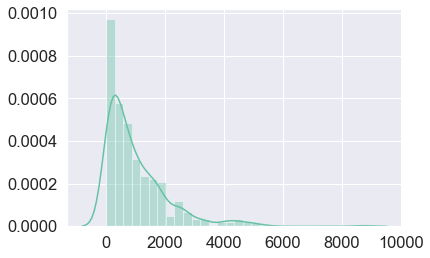

In [43]:
#?sns.distplot
df_expon = sps.expon(scale=1000).rvs(500)
sns.distplot(a = df_expon)

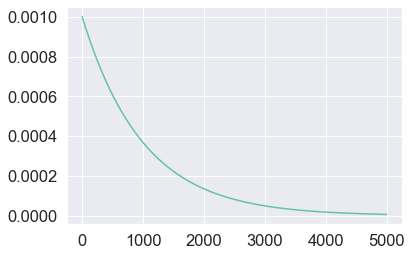

In [25]:
x = np.linspace(start=0,stop=5000,num=1000)
y = sps.expon(scale=l000).pdf(x)
df=pd.DataFrame({'x':x,'y':y})
#sns.relplot(x=x,y=y,data=df)
plt.plot(x,y)

In [17]:
#?np.linspace
#?sps.expon
?sns.relplot

### Относительный T-test критерий

Но теперь надо придумать, как это исправить. Предлагаю перейти к такой случайной величине:

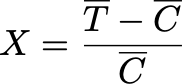

Утверждается, что её математическое ожидание — это именно то, что нам нужно в относительной постановке A/B-тестов.

Вообще, математическое ожидание у такой статистики не равно величине, которую мы хотим оценить в гипотезе относительного A/B-тестирования. Но здесь на помощь приходит разложение в многочлен Тейлора:

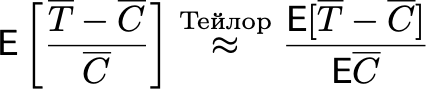

Но надо понять, как посчитать дисперсию этой статистики. Для этого предлагается применить дельта-метод. В итоге, формула дисперсии будет такой:

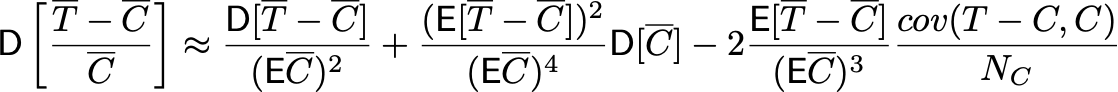
Если выборки разного размера:
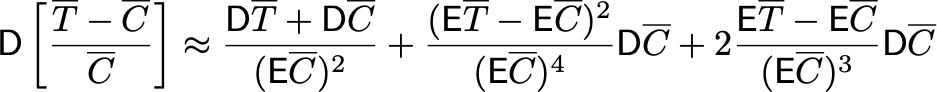

In [46]:
# 2. Create the testing criterio
def relative_ttest(control, test):
    control_mean = np.mean(control)
    test_mean = np.mean(test)
    control_mean_var = np.var(control) / len(control)
    test_mean_var = np.var(test) / len(test)
    
    difference_mean = test_mean - control_mean
    difference_mean_var = control_mean_var + test_mean_var
    
    relative_mean = difference_mean / control_mean
    relative_var = difference_mean_var/control_mean**2 \
                    + (difference_mean**2)/(control_mean**4) * control_mean_var \
                    + 2 * (difference_mean / (control_mean**3)) * control_mean_var
    relative_distribution = sps.norm(loc=relative_mean,scale=np.sqrt(relative_var))
    left_bound, right_bound = relative_distribution.ppf([0.025,0.975])
    ci_length = right_bound - left_bound
    pvalue = 2 * min(relative_distribution.cdf(0),relative_distribution.sf(0))
    effect = relative_mean
    
    result = ExperimentComparisonResults(pvalue, effect, ci_length, left_bound, right_bound)
    #print(f"control_mean, test_mean, control_mean_var, test_mean_var, difference_mean, difference_mean_var, relative_mean, relative_var: {control_mean}, {test_mean}, {control_mean_var}, {test_mean_var}, {difference_mean}, {difference_mean_var}, {relative_mean}, {relative_var}")
    #print(f'result: {result}')
    
    
    return ExperimentComparisonResults(pvalue, effect, ci_length, left_bound, right_bound)
    
    

In [49]:
# 3. Check the relative criterio on the simulated A/B test
%timeit
# counter of bad results
bad_cnt = 0
coef = 2

# cycle of cheking
N = 100000
for i in tqdm_notebook(range(N)):
    control = sps.expon(scale=1000).rvs(2000)
    test = sps.expon(scale=1000).rvs(2100)
    test *= coef
    
    # check with the criterio
    _,_,_, left_bound, right_bound = relative_ttest(control,test)
    #print(f'left_bound, right_bound: {left_bound}, {right_bound}')
    if left_bound > (coef - 1) or right_bound < (coef - 1):
        bad_cnt += 1
        
# confidence interval for the proportion of criterio mistakes
left_real_level, right_real_level = proportion_confint(count=bad_cnt, nobs=N,alpha=0.05,method='wilson')

#print(bad_cnt)
# result
print(f"Real proportion of mistakes: {round(bad_cnt / N, 4)}; "
     f"confidence interval for the proportion of criterio mistakes: [{left_real_level},{right_real_level}]")


  0%|          | 0/100000 [00:00<?, ?it/s]

Real proportion of mistakes: 0.0508; confidence interval for the proportion of criterio mistakes: [0.04940680573245604,0.05212770844919984]


Итак, относительный T-test критерий работает на искусственных данных. Но, возможно, у вас возник вопрос: а не ухудшим ли мы таким образом мощность критериев? Вдруг дополнительный шум в знаменателе так расширит доверительный интервал, что критерий станет бесполезным? И если раньше, с обычным критерием, мы детектировали эффект в 80% случаев, а сейчас только в 50%, то, очевидно, мы не будем пользоваться относительным критерием: мощность всегда превыше всего.

Ответ: нет, этого не произойдёт. Вот практический пример:

In [51]:
absolute_power_cnt = 0
relative_power_cnt = 0

# Cycle of checking
N = 10000
for i in tqdm_notebook(range(N)):
    test = sps.expon(scale=1000).rvs(10000)
    control = sps.expon(scale=1000).rvs(10000)*1.01
    _,_,_,rel_left_bound,rel_right_bound = relative_ttest(control=control,test=test)
    _,_,_,abs_left_bound,abs_right_bound = absolute_ttest(control=control,test=test)
    if i <= 10:
        print(i)
        print(f'rel_left_bound,rel_right_bound: {rel_left_bound},{rel_right_bound}')
        print(f'abs_left_bound,abs_right_bound: {abs_left_bound},{abs_right_bound}')
        
    if rel_left_bound > 0:
        relative_power_cnt += 1
    if abs_left_bound > 0:
        absolute_power_cnt += 1
print(f'Power of the relative criterio VS absolute criterio: {relative_power_cnt/N},{absolute_power_cnt/N}') 
    
    
    
    

  0%|          | 0/10000 [00:00<?, ?it/s]

rel_left_bound,rel_right_bound: -0.06043484810050004,-0.0068256259759843264
abs_left_bound,abs_right_bound: -62.57185577091507,-6.523421857195515
rel_left_bound,rel_right_bound: -0.05265151150378143,0.0013417492130255518
abs_left_bound,abs_right_bound: -54.17463511960621,1.7462997349994787
rel_left_bound,rel_right_bound: -0.0426807223434153,0.012790060852719068
abs_left_bound,abs_right_bound: -43.55094289056292,13.200579461076309
rel_left_bound,rel_right_bound: -0.04805133857682892,0.00595705625127621
abs_left_bound,abs_right_bound: -48.91242980450647,6.318783028412543
rel_left_bound,rel_right_bound: -0.029243097387620126,0.025086638803468925
abs_left_bound,abs_right_bound: -29.618769929556212,25.412967370552845
rel_left_bound,rel_right_bound: -0.045121779108266265,0.008853606086111722
abs_left_bound,abs_right_bound: -46.351315688028855,9.305174467738965
rel_left_bound,rel_right_bound: -0.05727227635362843,-0.0036783977627422443
abs_left_bound,abs_right_bound: -58.58837370431643,-3.305